In [40]:
import geopandas as gpd
import geopy.distance
import os
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# data_path = 'C:/Users/demo/Desktop/Lattitude/datas/'
data_path = 'datas'
os.makedirs(data_path, exist_ok=True)

In [13]:
# Load the data for French garge points
file_name = 'dataset_charge_points.feather'

bornes = gpd.read_feather(os.path.join(data_path, file_name))

# Load the data for the communes
file_name = 'dataset_communes.feather'

datas = gpd.read_feather(os.path.join(data_path, file_name))

file_name = 'TMJA2018'

tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))

--------

<Axes: >

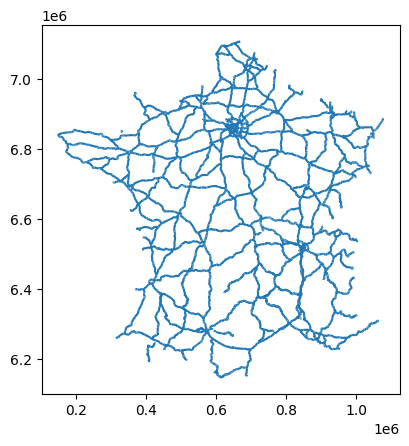

In [14]:
tmja.plot()

In [31]:
tmja_wrs84 = tmja.to_crs(4326)

In [34]:
tmja_wrs84.keys()

Index(['dateRefere', 'route', 'longueur', 'prD', 'depPrD', 'concession',
       'absD', 'cumulD', 'xD', 'yD', 'zD', 'prF', 'depPrF', 'concessi_1',
       'absF', 'cumulF', 'xF', 'yF', 'zF', 'cote', 'anneeMesur', 'typeCompta',
       'tmja', 'pctPL', 'geometry'],
      dtype='object')

In [35]:
geo_list = tmja_wrs84.geometry

In [37]:
geo_list

0       LINESTRING (4.85057 45.68163, 4.85068 45.68180...
1       LINESTRING (4.89002 45.78515, 4.89044 45.78476...
2       LINESTRING (4.86635 45.78915, 4.86652 45.78922...
3       LINESTRING (2.28085 48.87830, 2.28107 48.87860...
4       LINESTRING (2.28063 48.87837, 2.28082 48.87862...
                              ...                        
5963    LINESTRING (5.40975 43.33051, 5.40962 43.33043...
5964    LINESTRING (1.21422 43.68430, 1.21448 43.68436...
5965    LINESTRING (-0.25658 44.30029, -0.25652 44.300...
5966    LINESTRING (-0.00751 43.99087, -0.00751 43.990...
5967    LINESTRING (1.12568 43.63644, 1.12579 43.63636...
Name: geometry, Length: 5968, dtype: geometry

In [46]:
lenght_geolist = len(geo_list)
problematic_roads = []
points_list = []

for i in range(lenght_geolist):
    try:
        points_list.append(list(geo_list[i].coords))
    except:
        problematic_roads.append(i)
        points_list.append(['nan'])

tmja_wrs84['list_points'] = points_list

In [49]:
len(geo_list)

5968

In [48]:
len(problematic_roads)

74

In [32]:
tmja_wrs84['Road_center'] = tmja_wrs84.to_crs('+proj=cea').geometry.centroid.to_crs(tmja_wrs84.crs)

---------

In [53]:
datas[['nb_vp', 'nb_vp_rechargeables_gaz', 'nb_vp_rechargeables_el']].describe()

,nb_vp,nb_vp_rechargeables_gaz,nb_vp_rechargeables_el
count,314535.000000,314535.000000,314535.000000
mean,1863.089103,0.119955,19.333298
std,7242.008462,2.711924,103.856129
min,1.000000,0.000000,0.000000
25%,236.000000,0.000000,1.000000
50%,522.000000,0.000000,3.000000
75%,1285.000000,0.000000,10.000000
max,405637.000000,371.000000,6156.000000


In [54]:
datas.keys()

Index(['insee', 'nom', 'wikipedia', 'surf_ha', 'geometry', 'PMUN', 'PCAP',
       'PTOT', 'nb_vp', 'libepci', 'libgeo', 'nb_vp_rechargeables_gaz',
       'date_arrete', 'epci', 'nb_vp_rechargeables_el', 'dep', 'dep_name',
       'region_name'],
      dtype='object')

In [55]:
communes_fin_2022 = datas.loc[datas['date_arrete']=='2022-12-31']

In [56]:
communes_fin_2022[['nb_vp', 'nb_vp_rechargeables_gaz', 'nb_vp_rechargeables_el']].sum()

nb_vp                      65944969.0
nb_vp_rechargeables_gaz        4562.0
nb_vp_rechargeables_el       992737.0
dtype: float64

In [57]:
extra_metropole = [code_insee for code_insee in communes_fin_2022['insee'].to_list() if code_insee[0:2]=='2A' or code_insee[0:2]=='2B' or code_insee[0:2]=='97' or code_insee[0:2]=='98']

In [58]:
communes_metropole = communes_fin_2022.loc[~communes_fin_2022['insee'].isin(extra_metropole),:]

In [59]:
communes_metropole['coords_centre'] = communes_metropole.to_crs('+proj=cea').geometry.centroid.to_crs(communes_metropole.crs)

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


NameError: name 'communes_metropole' is not defined

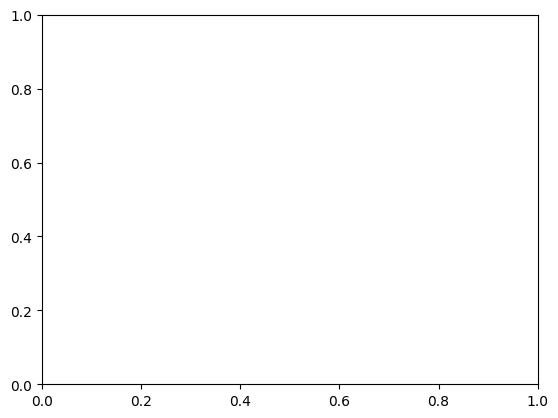

In [39]:


fig, ax = plt.subplots(1, 1)

communes_metropole['coords_centre'].plot(ax=ax)
tmja_wrs84['Road_center'].plot(ax=ax)


-----------

In [61]:
dep_13 = [code_insee for code_insee in communes_metropole['insee'].to_list() if code_insee[0:2]=='13']

In [62]:
communes_bdr_13 = communes_metropole.loc[communes_metropole['insee'].isin(dep_13),:]

In [63]:
communes_bdr_13 

,insee,nom,wikipedia,surf_ha,geometry,PMUN,PCAP,PTOT,nb_vp,libepci,libgeo,nb_vp_rechargeables_gaz,date_arrete,epci,nb_vp_rechargeables_el,dep,dep_name,region_name,coords_centre
13685,13107,Simiane-Collongue,fr:Simiane-Collongue,3004.0,"POLYGON ((5.39283 43.41646, 5.39400 43.41687, ...",5596.0,91.0,5687.0,6793.0,Métropole d'Aix-Marseille-Provence,SIMIANE-COLLONGUE,0.0,2022-12-31,200054807,177.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.43758 43.41151)
13686,13001,Aix-en-Provence,fr:Aix-en-Provence,18748.0,"POLYGON ((5.26947 43.49617, 5.26965 43.49648, ...",142482.0,3194.0,145676.0,154907.0,Métropole d'Aix-Marseille-Provence,AIX-EN-PROVENCE,132.0,2022-12-31,200054807,4284.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.39858 43.53607)
13687,13080,Le Puy-Sainte-Réparade,fr:Le Puy-Sainte-Réparade,4487.0,"POLYGON ((5.39213 43.64983, 5.39638 43.65622, ...",5719.0,92.0,5811.0,6797.0,Métropole d'Aix-Marseille-Provence,LE PUY-SAINTE-RÉPARADE,0.0,2022-12-31,200054807,184.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.43965 43.65158)
13905,13055,Marseille,fr:Marseille,24214.0,"MULTIPOLYGON (((5.22863 43.19774, 5.22866 43.1...",NaN,NaN,NaN,72.0,Métropole d'Aix-Marseille-Provence,MARSEILLE ND,0.0,2022-12-31,200054807,0.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.41910 43.29233)
13933,13064,Mollégès,fr:Mollégès,1426.0,"POLYGON ((4.90858 43.81207, 4.91584 43.81248, ...",2594.0,28.0,2622.0,2925.0,CA Terre de Provence,MOLLÉGÈS,0.0,2022-12-31,200035087,69.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (4.94933 43.80512)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16326,13072,Peynier,fr:Peynier,2476.0,"POLYGON ((5.58757 43.44272, 5.58875 43.44513, ...",3480.0,132.0,3612.0,4494.0,Métropole d'Aix-Marseille-Provence,PEYNIER,0.0,2022-12-31,200054807,135.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.62546 43.43975)
16327,13007,Auriol,fr:Auriol (Bouches-du-Rhône),4462.0,"POLYGON ((5.60689 43.37052, 5.60692 43.37061, ...",11908.0,176.0,12084.0,13753.0,Métropole d'Aix-Marseille-Provence,AURIOL,1.0,2022-12-31,200054807,317.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.65856 43.36071)
16328,13016,La Bouilladisse,fr:La Bouilladisse,1270.0,"POLYGON ((5.58188 43.40492, 5.58223 43.40497, ...",6194.0,81.0,6275.0,7227.0,Métropole d'Aix-Marseille-Provence,LA BOUILLADISSE,0.0,2022-12-31,200054807,242.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.62033 43.39699)
16329,13086,Roquevaire,fr:Roquevaire,2397.0,"POLYGON ((5.54614 43.34455, 5.54841 43.34434, ...",9003.0,142.0,9145.0,10923.0,Métropole d'Aix-Marseille-Provence,ROQUEVAIRE,4.0,2022-12-31,200054807,325.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.59774 43.34364)


In [26]:
DIST_VOL_OISEAU = 70000 # meters

In [71]:
nearlier_road = []
nearlier_road_dist = []
problematic_road = []

for k, coord_center in enumerate(communes_bdr_13['coords_centre'].geometry):

    list_index_nearly = []
    list_coord_nearly = []
    list_dist = []

    for i, road_center in enumerate(tmja_wrs84['Road_center'].geometry):
        #points_df = gpd.GeoDataFrame({'geometry': [coord_road, coord_center]}, crs='EPSG:4326')
        #points_df = points_df.to_crs('EPSG:5234')
        #points_df2 = points_df.shift()
        dist_oiseau = geopy.distance.geodesic(coord_center.coords, road_center.coords).meters
        if dist_oiseau<=DIST_VOL_OISEAU:
            list_index_nearly.append(i)
            try:
                list_coord_nearly.append([tupple_coord for tupple_coord in tmja_wrs84.geometry.to_list()[i].coords])
            except:
                list_coord_nearly.append([road_center.coords])
                problematic_road.append(tmja_wrs84.iloc[i, 1])
    
    # ICI, REMPLACER PAR CALCUL API DE DISTANCE TEMPORELLE ROUTIERE :
    # BOUCLE AVEC REQUETES À L'API POUR EVALUATION DU TEMPS ROUTIER DU POINT COMMUNE/CENTRE-VILLAGE
    # À CHAQUE POINT DE ROUTE DE LA LISTE
    #for coord_road in list_coord_nearly:
        # ...
        # best_dist =
        # best_index = 

    # SOLUTION DE REMPLACEMENT (VOL D'OISEAU)
    dist_minimal = DIST_VOL_OISEAU
    best_road = 'nan'

    for i, road_list_points in enumerate(list_coord_nearly):

        min_for_this_road = min([geopy.distance.geodesic(coord_center.coords, tupple).meters for tupple in road_list_points])

        if min_for_this_road < dist_minimal:
            dist_minimal = min_for_this_road

            best_road = list_index_nearly[i]

    nearlier_road_dist.append(dist_minimal)

    nearlier_road.append(tmja_wrs84.iloc[best_road,1])

    if k%100==0:
        print(f'{k} communes completed...')

communes_metropole['nearlier_road']=  nearlier_road
communes_metropole['nearlier_road_dist']=  nearlier_road_dist

0 communes completed...
100 communes completed...


ValueError: Length of values (119) does not match length of index (34461)

In [72]:
communes_bdr_13['nearlier_road'] = nearlier_road
communes_bdr_13['nearlier_road_dist']=  nearlier_road_dist

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [73]:
file_name = 'communes_with_nearlier_road_dept_13_test.feather'

communes_bdr_13.to_feather(os.path.join(data_path, file_name))

In [76]:
len(nearlier_road)

119

In [77]:
len(nearlier_road_dist)

119

In [80]:
set(problematic_road)

{'N0007', 'N0106', 'N0568', 'N0569'}

---------

In [5]:
file_name = 'communes_with_nearlier_road_dept_13_test.feather'

communes_bdr_13 = gpd.read_feather(os.path.join(data_path, file_name))

<Axes: >

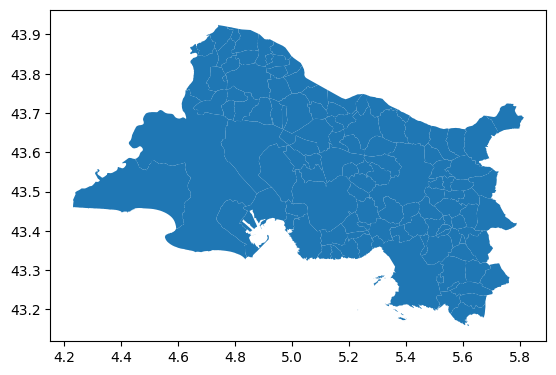

In [15]:
communes_bdr_13.plot()

<Axes: >

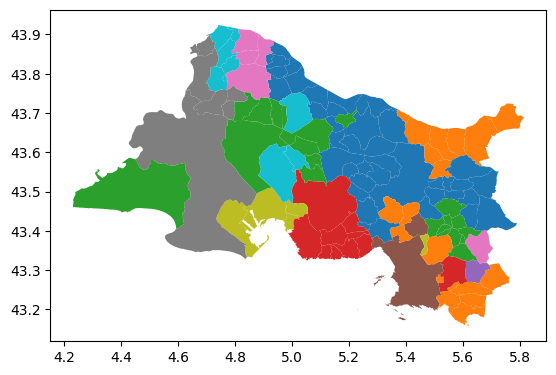

In [16]:
communes_bdr_13.plot(column='nearlier_road')

In [21]:
max(communes_bdr_13['nearlier_road_dist'])

22176.413320127114

In [24]:
np.log(1 + 12/100000)

0.00011999280057584615

In [27]:
communes_bdr_13['traffic_vp'] = communes_bdr_13['nb_vp']*(1/1+np.log(1 + communes_bdr_13['nearlier_road_dist']/DIST_VOL_OISEAU))

In [34]:
traffic_values = communes_bdr_13.groupby('nearlier_road')['traffic_vp'].sum().to_dict()

In [35]:
traffic_values.keys()

dict_keys(['A0007', 'A0008', 'A0050', 'A0051', 'A0052', 'A0054', 'A0055', 'A0501', 'A0502', 'A0507', 'A0515', 'A0520', 'N0007', 'N0100', 'N0113', 'N0547', 'N0568', 'N0569', 'N1007'])

In [36]:
tmja_wrs84_13 = tmja_wrs84.loc[tmja_wrs84['route'].isin(traffic_values.keys()),:]

<Axes: >

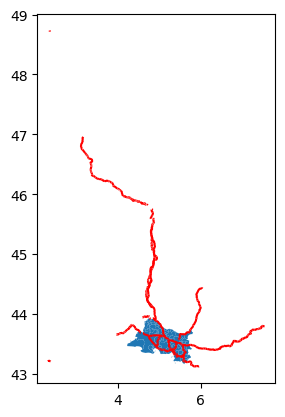

In [44]:
fig, ax = plt.subplots(1, 1)

communes_bdr_13.plot(ax=ax)
tmja_wrs84_13.plot(ax=ax, color='r')

In [45]:
tmja_wrs84_13

,dateRefere,route,longueur,prD,depPrD,concession,absD,cumulD,xD,yD,...,xF,yF,zF,cote,anneeMesur,typeCompta,tmja,pctPL,geometry,Road_center
276,2018-01-01,A0007,6222.0,0,69,N,0.0,0.0,842124.41,6518250.56,...,842815.69,6512880.20,0.0,I,0,None,0,0.0,"LINESTRING (4.82823 45.74904, 4.82827 45.74903...",POINT (4.82385 45.72464)
277,2018-01-01,A0007,1025.0,6,69,N,155.0,6222.0,842815.69,6512880.20,...,843448.06,6512130.20,0.0,I,2018,1,148668,7.9,"LINESTRING (4.83551 45.70055, 4.83558 45.70024...",POINT (4.83905 45.69646)
278,2018-01-01,A0007,334.0,7,69,N,170.0,7247.0,843448.06,6512130.20,...,843610.60,6511843.46,0.0,I,2018,1,148668,7.9,"LINESTRING (4.84341 45.69367, 4.84361 45.69356...",POINT (4.84456 45.69257)
279,2018-01-01,A0007,5799.0,7,69,N,504.0,7581.0,843610.60,6511843.46,...,842344.16,6506404.82,0.0,I,2018,1,148668,7.9,"LINESTRING (4.84541 45.69105, 4.84546 45.69086...",POINT (4.84107 45.66419)
280,2018-01-01,A0007,6720.0,13,69,N,350.0,13380.0,842344.16,6506404.82,...,840219.10,6500318.34,0.0,I,2018,1,99150,8.0,"LINESTRING (4.82753 45.64236, 4.82746 45.64230...",POINT (4.80933 45.61621)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5802,2018-01-01,N0569,4554.0,10,13,N,400.0,10900.0,858639.92,6275030.07,...,858847.92,6270457.14,0.0,I,2018,8,0,0.0,"MULTILINESTRING ((4.96283 43.55659, 4.96234 43...",POINT (4.95949 43.53747)
5803,2018-01-01,N0569,8208.0,15,13,N,132.0,15454.0,858847.92,6270457.14,...,855458.93,6264423.28,0.0,I,2018,8,0,0.0,"MULTILINESTRING ((4.96663 43.49968, 4.96657 43...",POINT (4.95004 43.48010)
5804,2018-01-01,N0569,14.0,23,13,N,939.0,23662.0,855458.93,6264423.28,...,855444.75,6264423.61,0.0,I,0,None,0,0.0,"LINESTRING (4.92030 43.46189, 4.92023 43.46190...",POINT (4.92021 43.46190)
5873,2018-01-01,N1007,639.0,22,84,N,0.0,0.0,842073.08,6316081.12,...,842335.63,6315506.52,0.0,I,2018,1,18703,0.0,"LINESTRING (4.76930 43.92941, 4.76938 43.92937...",POINT (4.77075 43.92665)
